# Module 13: Attention Mechanism

**The Bridge to Transformers**

---

## 1. Objectives

- ✅ Understand attention intuition
- ✅ Implement Bahdanau (additive) attention
- ✅ Implement Luong (multiplicative) attention
- ✅ Understand self-attention (foundation for Transformers)

## 2. Prerequisites

- [Module 12: Sequence-to-Sequence](../12_seq2seq/12_seq2seq.ipynb)

## 3. Why Attention?

### The Bottleneck Problem

In vanilla Seq2Seq:
```
"The cat sat on the mat" → [single context vector] → Translation
```

**Problem**: All information compressed into ONE vector!

### Attention Solution

```
Decoder can "look back" at ALL encoder states:

When generating "chat" (French for cat):
  → Attend to "cat" in source
  
When generating "tapis" (French for mat):
  → Attend to "mat" in source
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


## 4. Attention Equation

### Core Formula

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\text{score}(Q, K)\right) \cdot V$$

Where:
- **Q** (Query): What we're looking for
- **K** (Key): What we match against
- **V** (Value): What we return

### Score Functions

| Type | Formula | Name |
|------|---------|------|
| Additive | $v^T \tanh(W_q q + W_k k)$ | Bahdanau |
| Dot-product | $q^T k$ | Luong (dot) |
| Scaled dot | $\frac{q^T k}{\sqrt{d_k}}$ | Transformer |

## 5. Bahdanau (Additive) Attention

In [2]:
class BahdanauAttention(nn.Module):
    """Additive attention (Bahdanau et al., 2015)."""

    def __init__(self, hidden_dim):
        super().__init__()
        self.W_q = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_k = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, query, keys, mask=None):
        """
        Args:
            query: (batch, hidden) - decoder hidden state
            keys: (batch, src_len, hidden) - encoder outputs
            mask: (batch, src_len) - padding mask
        Returns:
            context: (batch, hidden)
            weights: (batch, src_len)
        """
        # query: (batch, 1, hidden)
        query = query.unsqueeze(1)

        # Score: v^T tanh(Wq*q + Wk*k)
        scores = self.v(torch.tanh(self.W_q(query) + self.W_k(keys)))  # (batch, src_len, 1)
        scores = scores.squeeze(-1)  # (batch, src_len)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        weights = F.softmax(scores, dim=1)  # (batch, src_len)
        context = torch.bmm(weights.unsqueeze(1), keys).squeeze(1)  # (batch, hidden)

        return context, weights

# Test
attn = BahdanauAttention(hidden_dim=128)
query = torch.randn(2, 128)  # batch=2
keys = torch.randn(2, 10, 128)  # src_len=10
context, weights = attn(query, keys)
print(f"Context: {context.shape}, Weights: {weights.shape}")
print(f"Weights sum: {weights.sum(dim=1)}")

Context: torch.Size([2, 128]), Weights: torch.Size([2, 10])
Weights sum: tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)


## 6. Luong (Multiplicative) Attention

In [3]:
class LuongAttention(nn.Module):
    """Multiplicative attention (Luong et al., 2015)."""

    def __init__(self, hidden_dim, method='dot'):
        super().__init__()
        self.method = method
        if method == 'general':
            self.W = nn.Linear(hidden_dim, hidden_dim, bias=False)

    def forward(self, query, keys, mask=None):
        """
        query: (batch, hidden)
        keys: (batch, src_len, hidden)
        """
        if self.method == 'dot':
            # score = q^T k
            scores = torch.bmm(keys, query.unsqueeze(2)).squeeze(2)  # (batch, src_len)
        elif self.method == 'general':
            # score = q^T W k
            scores = torch.bmm(keys, self.W(query).unsqueeze(2)).squeeze(2)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        weights = F.softmax(scores, dim=1)
        context = torch.bmm(weights.unsqueeze(1), keys).squeeze(1)

        return context, weights

# Test
for method in ['dot', 'general']:
    attn = LuongAttention(128, method=method)
    context, weights = attn(query, keys)
    print(f"{method}: Context {context.shape}, Weights {weights.shape}")

dot: Context torch.Size([2, 128]), Weights torch.Size([2, 10])
general: Context torch.Size([2, 128]), Weights torch.Size([2, 10])


## 7. Scaled Dot-Product Attention (Transformers!)

In [4]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Transformer-style attention.

    Args:
        query: (batch, seq_q, d_k)
        key: (batch, seq_k, d_k)
        value: (batch, seq_k, d_v)
    """
    d_k = query.size(-1)

    # scores = Q K^T / sqrt(d_k)
    scores = torch.bmm(query, key.transpose(1, 2)) / (d_k ** 0.5)  # (batch, seq_q, seq_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    weights = F.softmax(scores, dim=-1)
    output = torch.bmm(weights, value)  # (batch, seq_q, d_v)

    return output, weights

# Test
Q = torch.randn(2, 5, 64)  # batch=2, seq=5, dim=64
K = torch.randn(2, 10, 64)  # source seq=10
V = torch.randn(2, 10, 64)

output, weights = scaled_dot_product_attention(Q, K, V)
print(f"Output: {output.shape}, Weights: {weights.shape}")

Output: torch.Size([2, 5, 64]), Weights: torch.Size([2, 5, 10])


## 8. Self-Attention

In [5]:
class SelfAttention(nn.Module):
    """
    Self-attention: Q, K, V all come from same sequence.
    Foundation of Transformers!
    """

    def __init__(self, embed_dim):
        super().__init__()
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        """
        x: (batch, seq, embed)
        """
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        output, weights = scaled_dot_product_attention(Q, K, V, mask)
        return output, weights

# Test
self_attn = SelfAttention(embed_dim=64)
x = torch.randn(2, 8, 64)  # batch=2, seq=8
output, weights = self_attn(x)
print(f"Self-attention output: {output.shape}")
print(f"Each token attends to all tokens: weights shape = {weights.shape}")

Self-attention output: torch.Size([2, 8, 64])
Each token attends to all tokens: weights shape = torch.Size([2, 8, 8])


## 9. Visualizing Attention

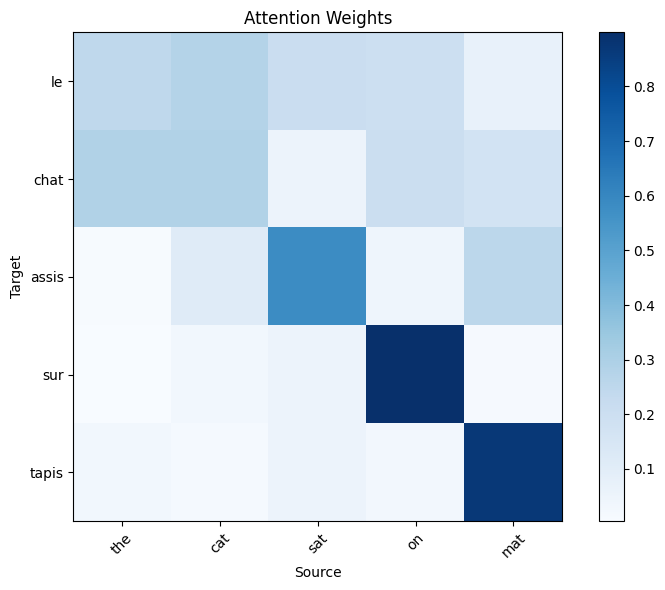

In [6]:
def visualize_attention(weights, src_tokens, tgt_tokens=None):
    """Visualize attention weights."""
    weights = weights.detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.imshow(weights, cmap='Blues')
    plt.colorbar()

    if tgt_tokens:
        plt.yticks(range(len(tgt_tokens)), tgt_tokens)
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=45)

    plt.xlabel('Source')
    plt.ylabel('Target')
    plt.title('Attention Weights')
    plt.tight_layout()
    plt.show()

# Simulated translation attention
src_tokens = ['the', 'cat', 'sat', 'on', 'mat']
tgt_tokens = ['le', 'chat', 'assis', 'sur', 'tapis']

# Simulated diagonal-ish attention (ideal for translation)
weights = torch.softmax(torch.randn(5, 5) + 2*torch.eye(5), dim=1)
visualize_attention(weights, src_tokens, tgt_tokens)

## 10. 🔥 Real-World Usage

### Attention Types Summary

| Type | Use Case | Key Insight |
|------|----------|-------------|
| **Bahdanau** | Seq2Seq translation | Additive, learned |
| **Luong** | Seq2Seq (simpler) | Multiplicative |
| **Self-attention** | Transformers | Q=K=V from same input |
| **Cross-attention** | Decoder attends to encoder | Q from decoder, K/V from encoder |

### Transformers = Self-Attention + More
- **BERT**: Encoder with self-attention
- **GPT**: Decoder with causal self-attention
- **T5**: Encoder-decoder with cross-attention

## 11. Interview Questions

**Q1: What is the difference between attention and self-attention?**
<details><summary>Answer</summary>

- **Attention**: Query from one sequence (decoder), Keys/Values from another (encoder)
- **Self-attention**: Q, K, V all come from the same sequence
</details>

**Q2: Why do we scale by sqrt(d_k)?**
<details><summary>Answer</summary>

For large d_k, dot products grow large in magnitude, pushing softmax into regions with tiny gradients. Dividing by sqrt(d_k) keeps variance stable.
</details>

## 12. Summary

- **Attention**: Dynamic focusing on relevant parts
- **Q, K, V**: Query, Key, Value paradigm
- **Bahdanau**: Additive attention (v^T tanh(...))
- **Luong**: Multiplicative (q^T k)
- **Self-attention**: Same sequence for Q, K, V → Transformers!

## 13. References

- [Bahdanau et al. 2015](https://arxiv.org/abs/1409.0473)
- [Luong et al. 2015](https://arxiv.org/abs/1508.04025)
- [Attention Is All You Need (2017)](https://arxiv.org/abs/1706.03762)

---
**Next:** [Module 14: Transformer Architecture](../14_transformer_architecture/14_transformer_architecture.ipynb)